# Compas Analysis

What follows are the calculations performed for ProPublica's analaysis of the COMPAS Recidivism Risk Scores. It might be helpful to open [the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/) in another tab to understand the following.

## Loading the Data

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [1]:
# filter dplyr warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
import pandas as pd
raw_data=pd.read_csv("/Users/zoyasyed/Downloads/Module4_Project/compas-scores-two-years .csv")
print(raw_data.shape)
raw_data.head()
raw_data['c_charge_degree'].value_counts()

(7214, 53)


F    4666
M    2548
Name: c_charge_degree, dtype: int64

However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [3]:
df=raw_data[((raw_data['days_b_screening_arrest'] <= 30) & 
   (raw_data['days_b_screening_arrest'] >= -30) &
   (raw_data['is_recid'] != -1)&
   (raw_data['c_charge_degree'] != "O") &
   (raw_data['score_text'] != 'N/A')
    )]
df=df.loc[:,['age', 'c_charge_degree','race', 'age_cat','score_text', 'sex', 'priors_count',
             'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
df.shape 

(6172, 13)

Higher COMPAS scores are slightly correlated with a longer length of stay. 

In [4]:
import datetime as dt
from scipy.stats import spearmanr
from scipy.stats import pearsonr
# These arr used to calculate correlation between variables:pearsonr(d1,d2),spearmanr(d1,d2)
def spear(d1,d2):
    corr,_=spearmanr(d1,d2)
    return corr
def pear(d1,d2):
    corr,_=pearsonr(d1,d2)
    return corr
df['length_of_stay'] = pd.to_datetime(df['c_jail_out'])-pd.to_datetime(df['c_jail_in'])
df['length_of_stay'] = round((df['length_of_stay'].dt.total_seconds())/86400).astype(int)
#Spearman's correlation coefficient = covariance(rank(X), rank(Y)) / (stdv(rank(X)) * stdv(rank(Y)))
print("Spearmanr Correlation:",spear(df['length_of_stay'], df['decile_score']))
#Pearson's correlation coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))
print("Pearsonr Correlation:",pear(df['length_of_stay'], df['decile_score']))

Spearmanr Correlation: 0.2808218823469897
Pearsonr Correlation: 0.20732969161470466


After filtering we have the following demographic breakdown:

In [5]:
df.age_cat.value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [6]:
df.race.value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [7]:
print("Black defendants: %.2f%%" %            (df.race.value_counts()[0]/ len(df) * 100))
print("White defendants: %.2f%%" %            (df.race.value_counts()[1]/ len(df) * 100))
print("Hispanic defendants: %.2f%%" %         (df.race.value_counts()[2]/ len(df) * 100))
print("Asian defendants: %.2f%%" %            (df.race.value_counts()[3]/ len(df) * 100))
print("Native American defendants: %.2f%%" %  (df.race.value_counts()[4]/ len(df) * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 5.56%
Native American defendants: 0.50%


In [8]:
df['score_text'].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [9]:
pd.crosstab(df.sex,df.race)

race    African-American  Asian  Caucasian  Hispanic  Native American  Other
sex                                                                         
Female               549      2        482        82                2     58
Male                2626     29       1621       427                9    285

In [10]:
df['sex'].value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [11]:
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))

Men: 80.96%
Women: 19.04%


In [12]:
print("Count of Two year Racid:",len(df[df['two_year_recid']==1]))

Count of Two year Racid: 2809


In [13]:
print("Percentage Of Two year Racid:",len(df[df['two_year_recid']==1]) / len(df) * 100)

Percentage Of Two year Racid: 45.51198963058976


Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

Text(0, 0.5, 'Count')

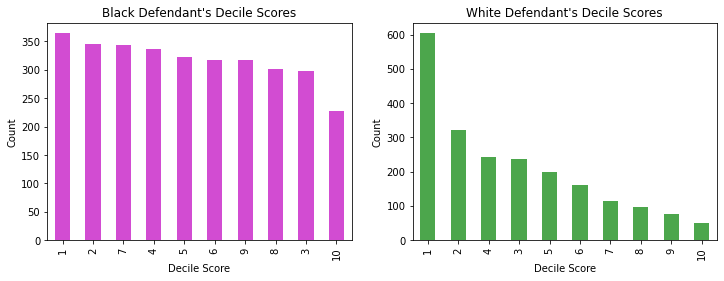

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,2,figsize=(12,4))
#df_sorted= df.sort_values('Salary')
Afr_Am = df.loc[df['race']=='African-American',:]['decile_score'].value_counts()
Cauc=df.loc[df['race']=='Caucasian',:]['decile_score'].value_counts()
Afr_Am.plot(kind='bar',ax=ax[0],color='m',alpha=0.7)
Cauc.plot(kind='bar',ax=ax[1],color='green',alpha=0.7)
ax[0].title.set_text("Black Defendant's Decile Scores") 
ax[1].title.set_text("White Defendant's Decile Scores")
ax[0].set_xlabel('Decile Score')
ax[1].set_xlabel('Decile Score')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')

In [15]:
pd.crosstab(df.decile_score,df.race)
df['score_text'].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

## Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [16]:
df_crime = pd.get_dummies(df['c_charge_degree'],prefix='crimefactor',drop_first=True)
df_age = pd.get_dummies(df['age_cat'],prefix='age')
df_race = pd.get_dummies(df['race'],prefix='race')
df_gender = pd.get_dummies(df['sex']=='Female',prefix='sex',drop_first=True)
df_score = pd.get_dummies(df['score_text'] != 'Low',prefix='score_factor',drop_first=True)

dflr = pd.concat([df_crime, df_age,df_race,df_gender,
                   df['priors_count'],df['two_year_recid']
                  ],axis=1)


Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [17]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
lr=LogisticRegression(solver='lbfgs')
lr.fit(dflr,df_score)
lr.intercept_

array([-1.54620469])

In [18]:
import numpy as np
cols = np.concatenate([df_crime.columns.values, 
                df_age.columns.values,
                df_race.columns.values,
                df_gender.columns.values,
                ['priors_count'],
                ['two_year_recid']
               ])

In [19]:
assert len(cols) == len(lr.coef_[0])
print('%.3f' % lr.intercept_, '(Intercept)') 
for i,j in zip(cols, lr.coef_[0]): print('%.3f' % j, i)

-1.546 (Intercept)
-0.310 crimefactor_M
0.016 age_25 - 45
-1.329 age_Greater than 45
1.317 age_Less than 25
0.485 race_African-American
-0.188 race_Asian
0.007 race_Caucasian
-0.418 race_Hispanic
0.917 race_Native American
-0.801 race_Other
0.218 sex_True
0.268 priors_count
0.683 two_year_recid


Women are 46.36% more likely than men to get a higher score.

In [21]:
import math
control=math.exp(-1.546)  / (1 + math.exp(-1.546))
math.exp(0.485) / (1 - control + (control * math.exp(0.485)))

1.463688129386762

In [22]:
math.exp(0.218 / (1 - control + (control * math.exp(0.218))))

1.232512321173068

Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

In [23]:

math.exp(1.317 ) / (1 - control + (control * math.exp(1.317 )))

2.5218428776143305

### Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.

In [24]:
import pandas as pd
raw_data=pd.read_csv("/Users/zoyasyed/Downloads/Module4_Project/compas-scores-two-years-violent.csv")
raw_data

id                name    first         last compas_screening_date  \
0         1    miguel hernandez   miguel    hernandez            2013-08-14   
1         3         kevon dixon    kevon        dixon            2013-01-27   
2         5         marcu brown    marcu        brown            2013-01-13   
3         6  bouthy pierrelouis   bouthy  pierrelouis            2013-03-26   
4         7        marsha miles   marsha        miles            2013-11-30   
...     ...                 ...      ...          ...                   ...   
4738  10995        raheem smith   raheem        smith            2013-10-20   
4739  10996       steven butler   steven       butler            2013-11-23   
4740  10997     malcolm simmons  malcolm      simmons            2014-02-01   
4741  10999     winston gregory  winston      gregory            2014-01-14   
4742  11000         farrah jean   farrah         jean            2014-03-09   

         sex         dob  age          age_cat              race  ...  \
0       Male  1947-04-18   69  Greater than 45             Other  ...   
1       Male  1982-01-22   34          25 - 45  African-American  ...   
2       Male  1993-01-21   23     Less than 25  African-American  ...   
3       Male  1973-01-22   43          25 - 45             Other  ...   
4       Male  1971-08-22   44          25 - 45             Other  ...   
...      ...         ...  ...              ...               ...  ...   
4738    Male  1995-06-28   20     Less than 25  African-American  ...   
4739    Male  1992-07-17   23     Less than 25  African-American  ...   
4740    Male  1993-03-25   23     Less than 25  African-American  ...   
4741    Male  1958-10-01   57  Greater than 45             Other  ...   
4742  Female  1982-11-17   33          25 - 45  African-American  ...   

      v_score_text  v_screening_date  in_custody  out_custody  priors_count.1  \
0              Low        2013-08-14  2014-07-07   2014-07-14               0   
1              Low        2013-01-27  2013-01-26   2013-02-05               0   
2           Medium        2013-01-13         NaN          NaN               1   
3              Low        2013-03-26         NaN          NaN               2   
4              Low        2013-11-30  2013-11-30   2013-12-01               0   
...            ...               ...         ...          ...             ...   
4738          High        2013-10-20  2014-04-07   2014-04-27               0   
4739        Medium        2013-11-23  2013-11-22   2013-11-24               0   
4740        Medium        2014-02-01  2014-01-31   2014-02-02               0   
4741           Low        2014-01-14  2014-01-13   2014-01-14               0   
4742           Low        2014-03-09  2014-03-08   2014-03-09               3   

      start   end event two_year_recid two_year_recid.1  
0         0   327     0              0                0  
1         9   159     1              1                1  
2         0  1174     0              0                0  
3         0  1102     0              0                0  
4         1   853     0              0                0  
...     ...   ...   ...            ...              ...  
4738      0   169     0              0                0  
4739      1   860     0              0                0  
4740      1   790     0              0                0  
4741      0   808     0              0                0  
4742      0   754     0              0                0  

[4743 rows x 54 columns]

In [25]:
df2=raw_data[(raw_data['days_b_screening_arrest'] <= 30)& 
          (raw_data['days_b_screening_arrest'] >= -30)&
          (raw_data['is_recid']!=-1) &
          (raw_data['c_charge_degree']!='O')&
          (raw_data['v_score_text']!='N/A')]
df2=df2.loc[:,['age', 'c_charge_degree','race', 'age_cat','v_score_text', 'sex', 'priors_count',
             'days_b_screening_arrest', 'v_decile_score', 'is_recid', 'two_year_recid']]
df2.shape

(4020, 11)

In [26]:
df2['age_cat'].value_counts()

25 - 45            2300
Greater than 45     954
Less than 25        766
Name: age_cat, dtype: int64

In [27]:
df2['race'].value_counts()

African-American    1918
Caucasian           1459
Hispanic             355
Other                255
Asian                 26
Native American        7
Name: race, dtype: int64

In [28]:
df2['v_score_text'].value_counts()

Low       2913
Medium     828
High       279
Name: v_score_text, dtype: int64

In [29]:
print("Recidivit Percentage:",len(df2.loc[df2['two_year_recid'] == 1]) / len(df2) * 100)

Recidivit count: 16.218905472636816


In [31]:

print("Recidivit count:",len(df2.loc[df2['two_year_recid'] == 1]))

Recidivit count: 652


Text(0, 0.5, 'Count')

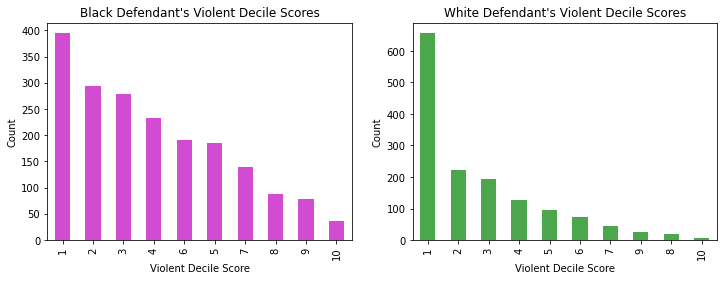

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,2,figsize=(12,4))
df2=df2.sort_values('v_decile_score')
Afr_Am = df2.loc[df2['race']=='African-American',:]['v_decile_score'].value_counts()
Cauc=df2.loc[df2['race']=='Caucasian',:]['v_decile_score'].value_counts()
Afr_Am.plot(kind='bar',ax=ax[0],color='m',alpha=0.7)
Cauc.plot(kind='bar',ax=ax[1],color='green',alpha=0.7)
ax[0].title.set_text("Black Defendant's Violent Decile Scores") 
ax[1].title.set_text("White Defendant's Violent Decile Scores")
ax[0].set_xlabel('Violent Decile Score')
ax[1].set_xlabel('Violent Decile Score')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')

In [35]:
df2_crime = pd.get_dummies(df2['c_charge_degree'],prefix='crimefactor',drop_first=True)
df2_age = pd.get_dummies(df2['age_cat'],prefix='age')
df2_race = pd.get_dummies(df2['race'],prefix='race')
df2_gender = pd.get_dummies(df2['sex']=='Female',prefix='sex_Female',drop_first=True)
df2_score = pd.get_dummies(df2['v_score_text'] != 'Low',prefix='score_factor',drop_first=True)
df2_lr=pd.concat([df2_crime, df2_age,df2_race,df2_gender,
                   df2['priors_count'],df2['two_year_recid']
                  ],axis=1)

In [36]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
#rit2=sm.Logit(df2_score,dflr2,method='binary')
lr2=LogisticRegression(solver='lbfgs')
lr2.fit(df2_lr,df2_score.values.ravel())
print("Intercept is:",lr2.intercept_)

Intercept is: [-1.76580462]


In [37]:
import numpy as np
cols = np.concatenate([df2_crime.columns.values, 
                df2_age.columns.values,
                df2_race.columns.values,
                df2_gender.columns.values,
                ['priors_count'],
                ['two_year_recid']
               ])

In [38]:
assert len(cols) == len(lr2.coef_[0])
print('%.3f' % lr2.intercept_, '(Intercept)') 
for i,j in zip(cols, lr2.coef_[0]): 
    print('%.3f' % j, i)

-1.766 (Intercept)
-0.166 crimefactor_M
-0.476 age_25 - 45
-2.155 age_Greater than 45
2.633 age_Less than 25
0.664 race_African-American
-0.653 race_Asian
0.008 race_Caucasian
-0.051 race_Hispanic
0.217 race_Native American
-0.183 race_Other
-0.708 sex_Female_True
0.136 priors_count
0.923 two_year_recid


The violent score overpredicts recidivism for black defendants by 70.5% compared to white defendants.

In [39]:
import math
control=math.exp(-1.766)  / (1 + math.exp(-1.766))
math.exp(0.664) / (1 - control + (control * math.exp(0.664)))

1.7075084468205413

In [40]:
math.exp(-0.708 ) / (1 - control + (control * math.exp(-0.708 )))

0.5320517937431098

Defendands under 25 are 4.8 times as likely to get a higher score as middle aged defendants.

In [41]:
math.exp(2.633) / (1 - control + (control * math.exp(2.633)))

4.821410530037686

## Predictive Accuracy of COMPAS

In order to test whether Compas scores do an accurate job of deciding whether an offender is Low, Medium or High risk,  we ran a Cox Proportional Hazards model. Northpointe, the company that created COMPAS and markets it to Law Enforcement, also ran a Cox model in their [validation study](http://cjb.sagepub.com/content/36/1/21.abstract).

We used the counting model and removed people when they were incarcerated. Due to errors in the underlying jail data, we need to filter out 32 rows that have an end date more than the start date. Considering that there are 13,334 total rows in the data, such a small amount of errors will not affect the results.

In [42]:
import pandas as pd
data=pd.read_csv("/Users/zoyasyed/Downloads/Module4_Project_Final/compas-analysis-master/cox-parsed.csv")
data=data.loc[(data['score_text'] != "N/A") & (data['end']>data['start'])]
data=data.sort_values('id',ascending=True).drop_duplicates('id',keep='first')
grp=data
grp.shape
grp = grp[grp['score_text'].notnull()]
grp.shape

(10314, 52)

In [43]:
grp['score_text'].value_counts()

Low       5751
Medium    2611
High      1952
Name: score_text, dtype: int64

In [44]:
grp['race'].value_counts()

African-American    5147
Caucasian           3569
Hispanic             944
Other                571
Asian                 51
Native American       32
Name: race, dtype: int64

In [45]:
from lifelines import CoxPHFitter
grp_race = pd.get_dummies(grp['race'],prefix='race_factor')
grp_score = pd.get_dummies(grp['score_text'],prefix='score_factor')
grp1=pd.concat([grp,grp_race,grp_score],axis=1)
grp1=grp1.drop_duplicates('id')
f=grp1[['start','end','event','score_factor_High','score_factor_Medium']]
cph=CoxPHFitter()
Cox=cph.fit(f,'end','event')
Cox.print_summary()

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7418 right-censored observations>
             duration col = 'end'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10314
number of events observed = 2896
   partial log-likelihood = -25308.06
         time fit was run = 2021-03-26 16:00:23 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
start                -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
score_factor_High     1.24       3.44       0.05             1.14             1.33                 3.14                 3.77
score_factor_Medium   0.82       2.28       0.04             0.74             0.91                 2.09                 2.49

                         z      p   -log2(p)
covariate                                   
start               -11.94 <0.005     106.80
score_factor_High    26.46 <0.005     510.26
score_factor_Medium  18.60 <0.005     254.18
---
Concordance = 0.63
Partial AIC = 50622.12
log-likelihood ratio test = 841.73 on 3 df
-log2(p) of ll-ratio test = 602.64

People placed in the High category are 3.44 times as likely to recidivate, and the COMPAS system's concordance 63.6%. This is lower than the accuracy quoted in the Northpoint study of 63%.

In [47]:
from lifelines import CoxPHFitter
cph=CoxPHFitter()
f1=grp1[['start','end','event','decile_score']]
cph.fit(f1,'end','event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7418 right-censored observations>
             duration col = 'end'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10314
number of events observed = 2896
   partial log-likelihood = -25241.47
         time fit was run = 2021-03-26 16:01:37 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
start         -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
decile_score   0.19       1.21       0.01             0.18             0.21                 1.20                 1.23

                  z      p   -log2(p)
covariate                            
start        -12.51 <0.005     116.78
decile_score  30.09 <0.005     658.47
---
Concordance = 0.67
Partial AIC = 50486.95
log-likelihood ratio test = 974.89 on 2 df
-log2(p) of ll-ratio test = 703.24

COMPAS's decile scores are a bit more accurate at 67%.

We can test if the algorithm is behaving differently across races by including a race interaction term in the cox model.

In [48]:
from lifelines import CoxPHFitter
cph=CoxPHFitter()
grp_race = pd.get_dummies(data['race'],prefix='race_factor')
grp_score = pd.get_dummies(data['score_text'],prefix='score_factor')
grp1=pd.concat([data,grp_race,grp_score],axis=1)
grp1['mul_score_Af']=grp1['score_factor_High']*grp1['race_factor_African-American']
grp1['mul_score_As']=grp1['score_factor_High']*grp1['race_factor_Asian']
grp1['mul_score_Hi']=grp1['score_factor_High']*grp1['race_factor_Hispanic']
grp1['mul_score_NA']=grp1['score_factor_High']*grp1['race_factor_Native American']
grp1['mul_score_Ot']=grp1['score_factor_High']*grp1['race_factor_Other']
grp1['mul_score_Af_m']=grp1['score_factor_Medium']*grp1['race_factor_African-American']
grp1['mul_score_As_m']=grp1['score_factor_Medium']*grp1['race_factor_Asian']
grp1['mul_score_Hi_m']=grp1['score_factor_Medium']*grp1['race_factor_Hispanic']
grp1['mul_score_NA_m']=grp1['score_factor_Medium']*grp1['race_factor_Native American']
grp1['mul_score_Ot_m']=grp1['score_factor_Medium']*grp1['race_factor_Other']
grp1=grp1.drop_duplicates('id')
f2=grp1[['start','end','event','score_factor_High','race_factor_African-American','race_factor_Asian','race_factor_Hispanic','race_factor_Native American','race_factor_Other','mul_score_Af','mul_score_As','mul_score_Hi','mul_score_NA','mul_score_Ot']]
f3=grp1[['start','end','event','score_factor_Medium','race_factor_African-American','race_factor_Asian','race_factor_Hispanic','race_factor_Native American','race_factor_Other','mul_score_Af_m','mul_score_As_m','mul_score_Hi_m','mul_score_NA_m','mul_score_Ot_m']]
cph_H=cph.fit(f2,'end','event')
print("CoxPHFitter with respect to scorefactor_high:",cph_H.print_summary())
cph_M=cph.fit(f3,'end','event')
print("CoxPHFitter with respect to scorefactor_Medium:",cph_M.print_summary())
#HR(Hazard Ratio)=exp(coef)=1. --no significant
#HR>1  --- increase in Hazard
#HR<1 ---Reduction in the hazard

<lifelines.CoxPHFitter: fitted with 10325 total observations, 7427 right-censored observations>
             duration col = 'end'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10325
number of events observed = 2898
   partial log-likelihood = -25448.49
         time fit was run = 2021-03-26 16:01:56 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
start                         -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
score_factor_High              1.04       2.83       0.09             0.86             1.21                 2.37                 3.37
race_factor_African-American   0.35       1.42       0.05             0.25             0.44                 1.29                 1.56
race_factor_Asian             -0.86       0.42       0.45            -1.74             0.02                 0.18                 1.02
race_factor_Hispanic          -0.06       0.95       0.08            -0.22             0.11                 0.80                 1.11
race_factor_Native American   -0.25       0.78       0.50            -1.23             0.73                 0.29                 2.08
race_factor_Other             -0.18       0.84       0.11            -0.39             0.03                 0.68                 1.03
mul_score_Af                  -0.30       0.74       0.10            -0.50            -0.10                 0.61                 0.91
mul_score_As                   1.59       4.90       0.74             0.15             3.03                 1.16                20.72
mul_score_Hi                  -0.09       0.91       0.20            -0.50             0.31                 0.61                 1.36
mul_score_NA                   0.61       1.85       0.71            -0.78             2.01                 0.46                 7.47
mul_score_Ot                   0.52       1.67       0.27            -0.01             1.05                 0.99                 2.84

                                  z      p   -log2(p)
covariate                                            
start                        -11.06 <0.005      91.99
score_factor_High             11.68 <0.005     102.33
race_factor_African-American   7.19 <0.005      40.51
race_factor_Asian             -1.91   0.06       4.15
race_factor_Hispanic          -0.66   0.51       0.98
race_factor_Native American   -0.50   0.62       0.70
race_factor_Other             -1.71   0.09       3.53
mul_score_Af                  -2.91 <0.005       8.11
mul_score_As                   2.16   0.03       5.02
mul_score_Hi                  -0.46   0.64       0.64
mul_score_NA                   0.86   0.39       1.36
mul_score_Ot                   1.91   0.06       4.15
---
Concordance = 0.61
Partial AIC = 50920.98
log-likelihood ratio test = 604.47 on 12 df
-log2(p) of ll-ratio test = 401.72

CoxPHFitter with respect to scorefactor_high: None


<lifelines.CoxPHFitter: fitted with 10325 total observations, 7427 right-censored observations>
             duration col = 'end'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10325
number of events observed = 2898
   partial log-likelihood = -25567.66
         time fit was run = 2021-03-26 16:01:58 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
start                         -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
score_factor_Medium            0.64       1.89       0.07             0.49             0.78                 1.64                 2.19
race_factor_African-American   0.51       1.66       0.05             0.41             0.61                 1.50                 1.83
race_factor_Asian             -0.71       0.49       0.45            -1.59             0.17                 0.20                 1.19
race_factor_Hispanic          -0.05       0.95       0.09            -0.23             0.12                 0.80                 1.13
race_factor_Native American   -0.09       0.91       0.50            -1.07             0.89                 0.34                 2.44
race_factor_Other             -0.09       0.91       0.11            -0.30             0.12                 0.74                 1.13
mul_score_Af_m                -0.38       0.68       0.09            -0.56            -0.21                 0.57                 0.81
mul_score_As_m                 0.64       1.89       0.73            -0.80             2.08                 0.45                 7.97
mul_score_Hi_m                 0.04       1.04       0.17            -0.29             0.38                 0.75                 1.46
mul_score_NA_m                 0.39       1.47       0.71            -1.01             1.78                 0.37                 5.93
mul_score_Ot_m                -0.18       0.84       0.24            -0.65             0.30                 0.52                 1.35

                                 z      p   -log2(p)
covariate                                           
start                        -9.15 <0.005      63.92
score_factor_Medium           8.65 <0.005      57.48
race_factor_African-American  9.89 <0.005      74.17
race_factor_Asian            -1.57   0.12       3.12
race_factor_Hispanic         -0.59   0.56       0.85
race_factor_Native American  -0.18   0.86       0.22
race_factor_Other            -0.84   0.40       1.32
mul_score_Af_m               -4.27 <0.005      15.65
mul_score_As_m                0.87   0.39       1.38
mul_score_Hi_m                0.25   0.80       0.32
mul_score_NA_m                0.54   0.59       0.77
mul_score_Ot_m               -0.74   0.46       1.11
---
Concordance = 0.59
Partial AIC = 51159.33
log-likelihood ratio test = 366.13 on 12 df
-log2(p) of ll-ratio test = 233.39

CoxPHFitter with respect to scorefactor_Medium: None


The interaction term shows a similar disparity as the logistic regression above.

High risk white defendants are 3.61 more likely than low risk white defendants, while High risk black defendants are 2.99 more likely than low.

In [49]:
import math
print("Black High Hazard: %.2f" % (math.exp(-0.18976 + 1.28350)))
print("White High Hazard: %.2f" % (math.exp(1.28350)))
print("Black Medium Hazard: %.2f" % (math.exp(0.84286-0.17261)))
print("White Medium Hazard: %.2f" % (math.exp(0.84286)))

Black High Hazard: 2.99
White High Hazard: 3.61
Black Medium Hazard: 1.95
White Medium Hazard: 2.32


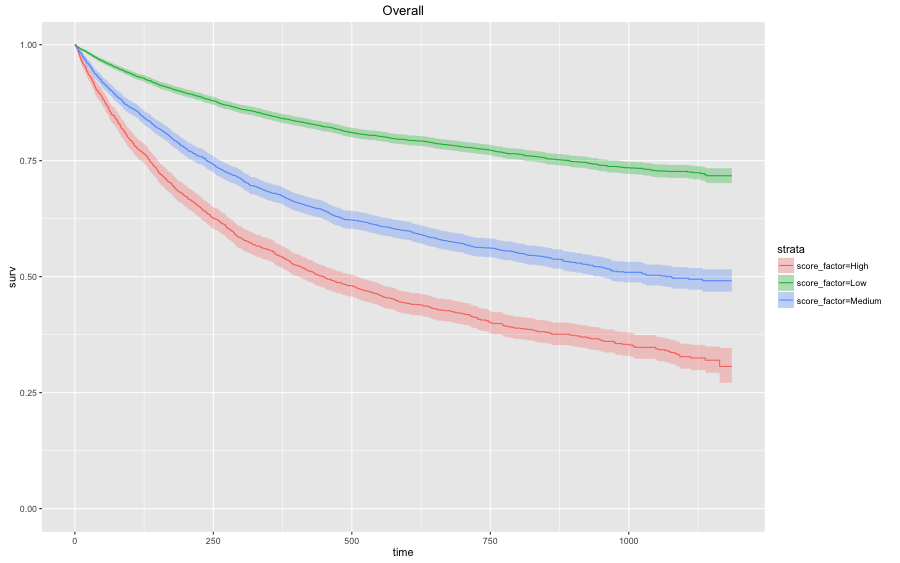

In [38]:
%%R -w 900 -h 563 -u px
library(survival)
library(ggfortify)

data <- filter(filter(read.csv("/Users/zoyasyed/Downloads/Module4_Project_Final/compas-analysis-master/cox-parsed.csv"), score_text != "N/A"), end > start) %>%
        mutate(race_factor = factor(race,
                                  labels = c("African-American", 
                                             "Asian",
                                             "Caucasian", 
                                             "Hispanic", 
                                             "Native American",
                                             "Other"))) %>%
        within(race_factor <- relevel(race_factor, ref = 3)) %>%
        mutate(score_factor = factor(score_text)) %>%
        within(score_factor <- relevel(score_factor, ref=2))

grp <- data[!duplicated(data$id),]
fit <- survfit(f, data=data)

plotty <- function(fit, title) {
  return(autoplot(fit, conf.int=T, censor=F) + ggtitle(title) + ylim(0,1))
}
plotty(fit, "Overall")

Black defendants do recidivate at higher rates according to race specific Kaplan Meier plots.

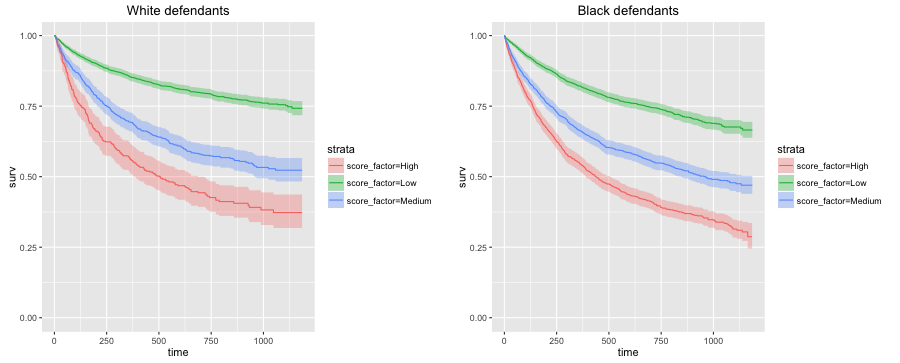

In [39]:
%%R -w 900 -h 363 -u px
white <- filter(data, race == "Caucasian")
white_fit <- survfit(f, data=white)

black <- filter(data, race == "African-American")
black_fit <- survfit(f, data=black)

grid.arrange(plotty(white_fit, "White defendants"), 
             plotty(black_fit, "Black defendants"), ncol=2)

In [50]:
from lifelines import KaplanMeierFitter
kmfl=KaplanMeierFitter()
kmfm=KaplanMeierFitter()
kmfh=KaplanMeierFitter()
#kmf.fit(durations=grp['end'],event_observed=grp['score_factor'])

kmfl.fit(durations=grp1['end'],event_observed=grp1['score_factor_Low'])

print('score_factor_Low\n',kmfl.event_table.loc[730,:],"\nSurvival function for low:",kmfl.survival_function_.loc[730,:])
kmfm.fit(durations=grp1['end'],event_observed=grp1['score_factor_Medium'])
print('score_factor_Medium\n',kmfm.event_table.loc[730,:],"\nSurvival function for Medium:",kmfm.survival_function_.loc[730,:])

kmfh.fit(durations=grp1['end'],event_observed=grp1['score_factor_High'])
print('score_factor_High\n',kmfh.event_table.loc[730,:],"\nSurvival function for High:",kmfh.survival_function_.loc[730,:])
#summary(fit, times=c(730))

score_factor_Low
 removed       10
observed       4
censored       6
entrance       0
at_risk     3654
Name: 730.0, dtype: int64 
Survival function for low: KM_estimate    0.572374
Name: 730.0, dtype: float64
score_factor_Medium
 removed       10
observed       3
censored       7
entrance       0
at_risk     3654
Name: 730.0, dtype: int64 
Survival function for Medium: KM_estimate    0.764563
Name: 730.0, dtype: float64
score_factor_High
 removed       10
observed       3
censored       7
entrance       0
at_risk     3654
Name: 730.0, dtype: int64 
Survival function for High: KM_estimate    0.807173
Name: 730.0, dtype: float64


In [51]:
kmfl=KaplanMeierFitter()
kmfm=KaplanMeierFitter()
kmfh=KaplanMeierFitter()
dat=grp1[['start','end','event','score_factor_High','score_factor_Medium','score_factor_Low','race']]
T=grp1['end']
E=grp1['score_factor_High']
E1=grp1['score_factor_Medium']
E2=grp1['score_factor_Low']
groups=grp1['race']
i1=(groups=='African-American')
i2=(groups=='Caucasian')
kmfl.fit(T[i1],E2[i1])
print('score_factor_Low for black Defendents\n',kmfl.event_table.loc[730,:],"\nSurvival function for low:",kmfl.survival_function_.loc[730,:])
kmfm.fit(T[i1],E1[i1])
print('score_factor_Medium for black Defendents\n',kmfm.event_table.loc[730,:],"\nSurvival function for Medium For Black:",kmfm.survival_function_.loc[730,:])
kmfh.fit(T[i1],E[i1])
print('score_factor_High for black Defendents\n',kmfh.event_table.loc[730,:],"\nSurvival function for High for Black:",kmfh.survival_function_.loc[730,:])


score_factor_Low for black Defendents
 removed        7
observed       2
censored       5
entrance       0
at_risk     1665
Name: 730.0, dtype: int64 
Survival function for low: KM_estimate    0.627919
Name: 730.0, dtype: float64
score_factor_Medium for black Defendents
 removed        7
observed       2
censored       5
entrance       0
at_risk     1665
Name: 730.0, dtype: int64 
Survival function for Medium For Black: KM_estimate    0.715
Name: 730.0, dtype: float64
score_factor_High for black Defendents
 removed        7
observed       3
censored       4
entrance       0
at_risk     1665
Name: 730.0, dtype: int64 
Survival function for High for Black: KM_estimate    0.717689
Name: 730.0, dtype: float64


In [53]:
kmfl=KaplanMeierFitter()
kmfm=KaplanMeierFitter()
kmfh=KaplanMeierFitter()
dat=grp1[['start','end','event','score_factor_High','score_factor_Medium','score_factor_Low','race']]
T=grp1['end']
E=grp1['score_factor_High']
E1=grp1['score_factor_Medium']
E2=grp1['score_factor_Low']
kmfl.fit(T[i2],E2[i2])
print('score_factor_Low for white Defendents\n',kmfl.event_table.loc[731,:],"\nSurvival function for low:",kmfl.survival_function_.loc[731,:])
kmfm.fit(T[i2],E1[i2])
print('score_factor_Medium White defendent\n',kmfm.event_table.loc[731,:],"\nSurvival function for Medium White defendent:",kmfm.survival_function_.loc[731,:])
kmfh.fit(T[i2],E[i2])
print('score_factor_High White defendent\n',kmfh.event_table.loc[731,:],"\nSurvival function for High White defendent:",kmfh.survival_function_.loc[731,:])


score_factor_Low for white Defendents
 removed        3
observed       2
censored       1
entrance       0
at_risk     1344
Name: 731.0, dtype: int64 
Survival function for low: KM_estimate    0.538195
Name: 731.0, dtype: float64
score_factor_Medium White defendent
 removed        3
observed       0
censored       3
entrance       0
at_risk     1344
Name: 731.0, dtype: int64 
Survival function for Medium White defendent: KM_estimate    0.792077
Name: 731.0, dtype: float64
score_factor_High White defendent
 removed        3
observed       1
censored       2
entrance       0
at_risk     1344
Name: 731.0, dtype: int64 
Survival function for High White defendent: KM_estimate    0.880673
Name: 731.0, dtype: float64


Race specific models have similar concordance values.

In [54]:
from lifelines import CoxPHFitter
cph_B=CoxPHFitter()
f2=grp1[['start','end','event','score_factor_High','score_factor_Medium','race_factor_African-American']]
cph_B=cph.fit(f2,'end','event')
print("CoxPHFitter with respect to scorefactor_high:",cph_B.print_summary())

<lifelines.CoxPHFitter: fitted with 10325 total observations, 7427 right-censored observations>
             duration col = 'end'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10325
number of events observed = 2898
   partial log-likelihood = -25317.43
         time fit was run = 2021-03-26 16:04:28 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
start                         -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
score_factor_High              1.17       3.22       0.05             1.07             1.26                 2.92                 3.54
score_factor_Medium            0.78       2.19       0.05             0.70             0.87                 2.00                 2.39
race_factor_African-American   0.19       1.21       0.04             0.12             0.27                 1.12                 1.31

                                  z      p   -log2(p)
covariate                                            
start                        -11.98 <0.005     107.39
score_factor_High             24.03 <0.005     421.49
score_factor_Medium           17.38 <0.005     222.45
race_factor_African-American   4.89 <0.005      19.89
---
Concordance = 0.65
Partial AIC = 50642.87
log-likelihood ratio test = 866.59 on 4 df
-log2(p) of ll-ratio test = 616.35

CoxPHFitter with respect to scorefactor_high: None


In [56]:
from lifelines import CoxPHFitter
cph_W=CoxPHFitter()
f3=grp1[['start','end','event','score_factor_High','score_factor_Medium','race_factor_Caucasian']]
cph_W=cph.fit(f3,'end','event')
print("CoxPHFitter with respect to scorefactor_Medium:",cph_W.print_summary())

<lifelines.CoxPHFitter: fitted with 10325 total observations, 7427 right-censored observations>
             duration col = 'end'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10325
number of events observed = 2898
   partial log-likelihood = -25324.74
         time fit was run = 2021-03-26 16:05:05 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
start                  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
score_factor_High       1.21       3.35       0.05             1.12             1.30                 3.05                 3.68
score_factor_Medium     0.81       2.25       0.04             0.72             0.90                 2.06                 2.46
race_factor_Caucasian  -0.13       0.88       0.04            -0.21            -0.05                 0.81                 0.96

                           z      p   -log2(p)
covariate                                     
start                 -11.97 <0.005     107.36
score_factor_High      25.50 <0.005     474.10
score_factor_Medium    18.24 <0.005     244.63
race_factor_Caucasian  -3.05 <0.005       8.77
---
Concordance = 0.64
Partial AIC = 50657.47
log-likelihood ratio test = 851.99 on 4 df
-log2(p) of ll-ratio test = 605.84

CoxPHFitter with respect to scorefactor_Medium: None


Compas's violent recidivism score has a slightly higher overall concordance score of 65.1%.

In [57]:
import pandas as pd
data_cv=pd.read_csv("/Users/zoyasyed/Downloads/Module4_Project_Final/compas-analysis-master/cox-violent-parsed.csv")
data_cv=data_cv.loc[(data_cv['v_score_text'] != "N/A") & (data_cv['end']>data_cv['start'])] 
grp=data_cv.sort_values('id',ascending=True).drop_duplicates('id',keep='first')
grp = grp[(grp['v_score_text'].notnull()) & (grp['race'].notnull())]
grp.shape

(10994, 52)

In this case, there isn't a significant coefficient on African American's with High Scores.

In [58]:
from lifelines import CoxPHFitter
cph=CoxPHFitter()
grp_race = pd.get_dummies(data_cv['race'],prefix='race_factor')
grp_score = pd.get_dummies(data_cv['v_score_text'],prefix='score_factor')
grp1v=pd.concat([data,grp_race,grp_score],axis=1)
grp1v['mul_score_Af']=grp1v['score_factor_High']*grp1v['race_factor_African-American']
grp1v['mul_score_As']=grp1v['score_factor_High']*grp1v['race_factor_Asian']
grp1v['mul_score_Hi']=grp1v['score_factor_High']*grp1v['race_factor_Hispanic']
grp1v['mul_score_NA']=grp1v['score_factor_High']*grp1v['race_factor_Native American']
grp1v['mul_score_Ot']=grp1v['score_factor_High']*grp1v['race_factor_Other']
grp1v['mul_score_Af_m']=grp1v['score_factor_Medium']*grp1v['race_factor_African-American']
grp1v['mul_score_As_m']=grp1v['score_factor_Medium']*grp1v['race_factor_Asian']
grp1v['mul_score_Hi_m']=grp1v['score_factor_Medium']*grp1v['race_factor_Hispanic']
grp1v['mul_score_NA_m']=grp1v['score_factor_Medium']*grp1v['race_factor_Native American']
grp1v['mul_score_Ot_m']=grp1v['score_factor_Medium']*grp1v['race_factor_Other']
grp1v=grp1.drop_duplicates('id')
f2=grp1v[['start','end','event','score_factor_High','race_factor_African-American','race_factor_Asian','race_factor_Hispanic','race_factor_Native American','race_factor_Other','mul_score_Af','mul_score_As','mul_score_Hi','mul_score_NA','mul_score_Ot']]
f3=grp1v[['start','end','event','score_factor_Medium','race_factor_African-American','race_factor_Asian','race_factor_Hispanic','race_factor_Native American','race_factor_Other','mul_score_Af_m','mul_score_As_m','mul_score_Hi_m','mul_score_NA_m','mul_score_Ot_m']]
cph_H=cph.fit(f2,'end','event')
print("CoxPHFitter with respect to scorefactor_high:",cph_H.print_summary())
cph_M=cph.fit(f3,'end','event')
print("CoxPHFitter with respect to scorefactor_Medium:",cph_M.print_summary())
#HR(Hazard Ratio)=exp(coef)=1. --no significant
#HR>1  --- increase in Hazard
#HR<1 ---Reduction in the hazard


<lifelines.CoxPHFitter: fitted with 10325 total observations, 7427 right-censored observations>
             duration col = 'end'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10325
number of events observed = 2898
   partial log-likelihood = -25448.49
         time fit was run = 2021-03-26 16:05:46 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
start                         -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
score_factor_High              1.04       2.83       0.09             0.86             1.21                 2.37                 3.37
race_factor_African-American   0.35       1.42       0.05             0.25             0.44                 1.29                 1.56
race_factor_Asian             -0.86       0.42       0.45            -1.74             0.02                 0.18                 1.02
race_factor_Hispanic          -0.06       0.95       0.08            -0.22             0.11                 0.80                 1.11
race_factor_Native American   -0.25       0.78       0.50            -1.23             0.73                 0.29                 2.08
race_factor_Other             -0.18       0.84       0.11            -0.39             0.03                 0.68                 1.03
mul_score_Af                  -0.30       0.74       0.10            -0.50            -0.10                 0.61                 0.91
mul_score_As                   1.59       4.90       0.74             0.15             3.03                 1.16                20.72
mul_score_Hi                  -0.09       0.91       0.20            -0.50             0.31                 0.61                 1.36
mul_score_NA                   0.61       1.85       0.71            -0.78             2.01                 0.46                 7.47
mul_score_Ot                   0.52       1.67       0.27            -0.01             1.05                 0.99                 2.84

                                  z      p   -log2(p)
covariate                                            
start                        -11.06 <0.005      91.99
score_factor_High             11.68 <0.005     102.33
race_factor_African-American   7.19 <0.005      40.51
race_factor_Asian             -1.91   0.06       4.15
race_factor_Hispanic          -0.66   0.51       0.98
race_factor_Native American   -0.50   0.62       0.70
race_factor_Other             -1.71   0.09       3.53
mul_score_Af                  -2.91 <0.005       8.11
mul_score_As                   2.16   0.03       5.02
mul_score_Hi                  -0.46   0.64       0.64
mul_score_NA                   0.86   0.39       1.36
mul_score_Ot                   1.91   0.06       4.15
---
Concordance = 0.61
Partial AIC = 50920.98
log-likelihood ratio test = 604.47 on 12 df
-log2(p) of ll-ratio test = 401.72

CoxPHFitter with respect to scorefactor_high: None


<lifelines.CoxPHFitter: fitted with 10325 total observations, 7427 right-censored observations>
             duration col = 'end'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10325
number of events observed = 2898
   partial log-likelihood = -25567.66
         time fit was run = 2021-03-26 16:05:47 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
start                         -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
score_factor_Medium            0.64       1.89       0.07             0.49             0.78                 1.64                 2.19
race_factor_African-American   0.51       1.66       0.05             0.41             0.61                 1.50                 1.83
race_factor_Asian             -0.71       0.49       0.45            -1.59             0.17                 0.20                 1.19
race_factor_Hispanic          -0.05       0.95       0.09            -0.23             0.12                 0.80                 1.13
race_factor_Native American   -0.09       0.91       0.50            -1.07             0.89                 0.34                 2.44
race_factor_Other             -0.09       0.91       0.11            -0.30             0.12                 0.74                 1.13
mul_score_Af_m                -0.38       0.68       0.09            -0.56            -0.21                 0.57                 0.81
mul_score_As_m                 0.64       1.89       0.73            -0.80             2.08                 0.45                 7.97
mul_score_Hi_m                 0.04       1.04       0.17            -0.29             0.38                 0.75                 1.46
mul_score_NA_m                 0.39       1.47       0.71            -1.01             1.78                 0.37                 5.93
mul_score_Ot_m                -0.18       0.84       0.24            -0.65             0.30                 0.52                 1.35

                                 z      p   -log2(p)
covariate                                           
start                        -9.15 <0.005      63.92
score_factor_Medium           8.65 <0.005      57.48
race_factor_African-American  9.89 <0.005      74.17
race_factor_Asian            -1.57   0.12       3.12
race_factor_Hispanic         -0.59   0.56       0.85
race_factor_Native American  -0.18   0.86       0.22
race_factor_Other            -0.84   0.40       1.32
mul_score_Af_m               -4.27 <0.005      15.65
mul_score_As_m                0.87   0.39       1.38
mul_score_Hi_m                0.25   0.80       0.32
mul_score_NA_m                0.54   0.59       0.77
mul_score_Ot_m               -0.74   0.46       1.11
---
Concordance = 0.59
Partial AIC = 51159.33
log-likelihood ratio test = 366.13 on 12 df
-log2(p) of ll-ratio test = 233.39

CoxPHFitter with respect to scorefactor_Medium: None


In [59]:
from lifelines import CoxPHFitter
cph_B=CoxPHFitter()
cph_W=CoxPHFitter()
f2=grp1v[['start','end','event','score_factor_High','score_factor_Medium','race_factor_African-American']]
cph_B=cph.fit(f2,'end','event')
print("CoxPHFitter with respect to scorefactor_high:",cph_B.print_summary())

<lifelines.CoxPHFitter: fitted with 10325 total observations, 7427 right-censored observations>
             duration col = 'end'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10325
number of events observed = 2898
   partial log-likelihood = -25317.43
         time fit was run = 2021-03-26 16:06:03 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
start                         -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
score_factor_High              1.17       3.22       0.05             1.07             1.26                 2.92                 3.54
score_factor_Medium            0.78       2.19       0.05             0.70             0.87                 2.00                 2.39
race_factor_African-American   0.19       1.21       0.04             0.12             0.27                 1.12                 1.31

                                  z      p   -log2(p)
covariate                                            
start                        -11.98 <0.005     107.39
score_factor_High             24.03 <0.005     421.49
score_factor_Medium           17.38 <0.005     222.45
race_factor_African-American   4.89 <0.005      19.89
---
Concordance = 0.65
Partial AIC = 50642.87
log-likelihood ratio test = 866.59 on 4 df
-log2(p) of ll-ratio test = 616.35

CoxPHFitter with respect to scorefactor_high: None


In [60]:
f3=grp1v[['start','end','event','score_factor_High','score_factor_Medium','race_factor_Caucasian']]
cph_W=cph.fit(f3,'end','event')
print("CoxPHFitter with respect to scorefactor_Medium:",cph_W.print_summary())

<lifelines.CoxPHFitter: fitted with 10325 total observations, 7427 right-censored observations>
             duration col = 'end'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10325
number of events observed = 2898
   partial log-likelihood = -25324.74
         time fit was run = 2021-03-26 16:06:18 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
start                  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
score_factor_High       1.21       3.35       0.05             1.12             1.30                 3.05                 3.68
score_factor_Medium     0.81       2.25       0.04             0.72             0.90                 2.06                 2.46
race_factor_Caucasian  -0.13       0.88       0.04            -0.21            -0.05                 0.81                 0.96

                           z      p   -log2(p)
covariate                                     
start                 -11.97 <0.005     107.36
score_factor_High      25.50 <0.005     474.10
score_factor_Medium    18.24 <0.005     244.63
race_factor_Caucasian  -3.05 <0.005       8.77
---
Concordance = 0.64
Partial AIC = 50657.47
log-likelihood ratio test = 851.99 on 4 df
-log2(p) of ll-ratio test = 605.84

CoxPHFitter with respect to scorefactor_Medium: None


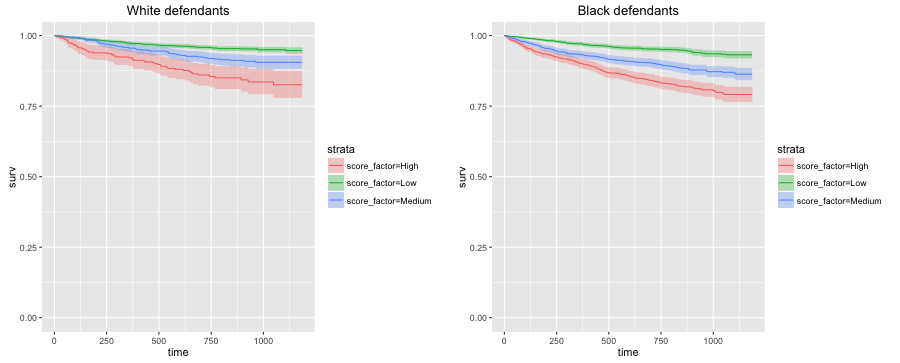

In [49]:
%%R -w 900 -h 363 -u px

violent_data <- filter(filter(read.csv("/Users/zoyasyed/Downloads/Module4_Project_Final/compas-analysis-master/cox-violent-parsed.cs"), score_text != "N/A"), end > start) %>%
        mutate(race_factor = factor(race,
                                  labels = c("African-American", 
                                             "Asian",
                                             "Caucasian", 
                                             "Hispanic", 
                                             "Native American",
                                             "Other"))) %>%
        within(race_factor <- relevel(race_factor, ref = 3)) %>%
        mutate(score_factor = factor(score_text)) %>%
        within(score_factor <- relevel(score_factor, ref=2))


vf <- Surv(start, end, event, type="counting") ~ score_factor
vmodel <- coxph(vf, data=violent_data)
vgrp <- violent_data[!duplicated(violent_data$id),]
white <- filter(violent_data, race == "Caucasian")
white_fit <- survfit(vf, data=white)

black <- filter(violent_data, race == "African-American")
black_fit <- survfit(vf, data=black)

grid.arrange(plotty(white_fit, "White defendants"), 
             plotty(black_fit, "Black defendants"), ncol=2)

## Directions of the Racial Bias

The above analysis shows that the Compas algorithm does overpredict African-American defendant's future recidivism, but we haven't yet explored the direction of the bias. We can discover fine differences in overprediction and underprediction by comparing Compas scores across racial lines.

In [61]:
from truth_tables import PeekyReader, Person, table, is_race, count, vtable, hightable, vhightable
from csv import DictReader

people = []
with open("/Users/zoyasyed/Downloads/Module4_Project_Final/compas-analysis-master/cox-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                people.append(p)
    except StopIteration:
        pass

pop = list(filter(lambda i: ((i.recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.score_valid, people))))
recid = list(filter(lambda i: i.recidivist == True and i.lifetime <= 730, pop))
rset = set(recid)
surv = [i for i in pop if i not in rset]

In [62]:
print("All defendants")
table(list(recid), list(surv))

All defendants
           	Low	High
Survived   	2681	1282	0.55
Recidivated	1216	2035	0.45
Total: 7214.00
False positive rate: 32.35
False negative rate: 37.40
Specificity: 0.68
Sensitivity: 0.63
Prevalence: 0.45
PPV: 0.61
NPV: 0.69
LR+: 1.94
LR-: 0.55


In [63]:
print("Total pop: %i" % (2681 + 1282 + 1216 + 2035))

Total pop: 7214


In [64]:
import statistics
print("Average followup time %.2f (sd %.2f)" % (statistics.mean(map(lambda i: i.lifetime, pop)),
                                                statistics.stdev(map(lambda i: i.lifetime, pop))))
print("Median followup time %i" % (statistics.median(map(lambda i: i.lifetime, pop))))

Average followup time 622.87 (sd 392.19)
Median followup time 766


Overall, the false positive rate is 32.35%.

In [65]:
print("Black defendants")
is_afam = is_race("African-American")
table(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

Black defendants
           	Low	High
Survived   	990	805	0.49
Recidivated	532	1369	0.51
Total: 3696.00
False positive rate: 44.85
False negative rate: 27.99
Specificity: 0.55
Sensitivity: 0.72
Prevalence: 0.51
PPV: 0.63
NPV: 0.65
LR+: 1.61
LR-: 0.51


That number is higher for African Americans at 44.85%.

In [66]:
print("White defendants")
is_white = is_race("Caucasian")
table(list(filter(is_white, recid)), list(filter(is_white, surv)))

White defendants
           	Low	High
Survived   	1139	349	0.61
Recidivated	461	505	0.39
Total: 2454.00
False positive rate: 23.45
False negative rate: 47.72
Specificity: 0.77
Sensitivity: 0.52
Prevalence: 0.39
PPV: 0.59
NPV: 0.71
LR+: 2.23
LR-: 0.62


And lower for whites at 23.45%.

In [67]:
44.85 / 23.45

1.9125799573560769

Which means under COMPAS black defendants are 91% more likely to get a higher score and not go on to commit more crimes than white defendants after two year.

COMPAS scores misclassify white reoffenders as low risk at 70.4% more often than black reoffenders.

In [68]:
47.72 / 27.99

1.7048946052161487

In [69]:
hightable(list(filter(is_white, recid)), list(filter(is_white, surv)))

           	Low	High
Survived   	1407	81	0.61
Recidivated	771	195	0.39
Total: 2454.00
False positive rate: 5.44
False negative rate: 79.81
Specificity: 0.95
Sensitivity: 0.20
Prevalence: 0.39
PPV: 0.71
NPV: 0.65
LR+: 3.71
LR-: 0.84


In [70]:
hightable(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

           	Low	High
Survived   	1511	284	0.49
Recidivated	1160	741	0.51
Total: 3696.00
False positive rate: 15.82
False negative rate: 61.02
Specificity: 0.84
Sensitivity: 0.39
Prevalence: 0.51
PPV: 0.72
NPV: 0.57
LR+: 2.46
LR-: 0.72


## Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score.

In [71]:
vpeople = []
with open("/Users/zoyasyed/Downloads/Module4_Project_Final/compas-analysis-master/cox-violent-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                vpeople.append(p)
    except StopIteration:
        pass

vpop = list(filter(lambda i: ((i.violent_recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.vscore_valid, vpeople))))
vrecid = list(filter(lambda i: i.violent_recidivist == True and i.lifetime <= 730, vpeople))
vrset = set(vrecid)
vsurv = [i for i in vpop if i not in vrset]

In [72]:
print("All defendants")
vtable(list(vrecid), list(vsurv))

All defendants
           	Low	High
Survived   	4121	1597	0.89
Recidivated	347	389	0.11
Total: 6454.00
False positive rate: 27.93
False negative rate: 47.15
Specificity: 0.72
Sensitivity: 0.53
Prevalence: 0.11
PPV: 0.20
NPV: 0.92
LR+: 1.89
LR-: 0.65


Even moreso for Black defendants.

In [73]:
print("Black defendants")
is_afam = is_race("African-American")
vtable(list(filter(is_afam, vrecid)), list(filter(is_afam, vsurv)))

Black defendants
           	Low	High
Survived   	1692	1043	0.86
Recidivated	170	273	0.14
Total: 3178.00
False positive rate: 38.14
False negative rate: 38.37
Specificity: 0.62
Sensitivity: 0.62
Prevalence: 0.14
PPV: 0.21
NPV: 0.91
LR+: 1.62
LR-: 0.62


In [74]:
print("White defendants")
is_white = is_race("Caucasian")
vtable(list(filter(is_white, vrecid)), list(filter(is_white, vsurv)))

White defendants
           	Low	High
Survived   	1679	380	0.91
Recidivated	129	77	0.09
Total: 2265.00
False positive rate: 18.46
False negative rate: 62.62
Specificity: 0.82
Sensitivity: 0.37
Prevalence: 0.09
PPV: 0.17
NPV: 0.93
LR+: 2.03
LR-: 0.77


Black defendants are twice as likely to be false positives for a Higher violent score than white defendants.

In [75]:
38.14 / 18.46

2.066088840736728

White defendants are 63% more likely to get a lower score and commit another crime than Black defendants.

In [76]:
62.62 / 38.37

1.63200416992442

## Gender differences in Compas scores

In terms of underlying recidivism rates, we can look at gender specific Kaplan Meier estimates. There is a striking difference between women and men.

In [77]:
from lifelines import KaplanMeierFitter
kmfl=KaplanMeierFitter()
kmfm=KaplanMeierFitter()
kmfh=KaplanMeierFitter()
dat=grp1v[['start','end','event','score_factor_High','score_factor_Medium','score_factor_Low','sex']]
T=dat['end']
E=dat['score_factor_High']
E1=dat['score_factor_Medium']
E2=dat['score_factor_Low']
groups=dat['sex']
i1=(groups=='Male')
i2=(groups=='Female')

In [78]:
kmfl.fit(T[i1],E2[i1])
print('score_factor_Low For Male defendents\n',kmfl.event_table.loc[730,:],"\nSurvival function for Low For Male defendents:",kmfl.survival_function_.loc[730,:])

kmfm.fit(T[i1],E1[i1])
print('score_factor_Medium For Male defendents\n',kmfm.event_table.loc[730,:],"\nSurvival function for Medium For Male defendents:",kmfm.survival_function_.loc[730,:])

kmfh.fit(T[i1],E[i1])
print('score_factor_High For Male defendents\n',kmfh.event_table.loc[730,:],"\nSurvival function for High For Male defendents:",kmfh.survival_function_.loc[730,:])


score_factor_Low For Male defendents
 removed        9
observed       3
censored       6
entrance       0
at_risk     2842
Name: 730.0, dtype: int64 
Survival function for Low For Male defendents: KM_estimate    0.570516
Name: 730.0, dtype: float64
score_factor_Medium For Male defendents
 removed        9
observed       3
censored       6
entrance       0
at_risk     2842
Name: 730.0, dtype: int64 
Survival function for Medium For Male defendents: KM_estimate    0.765531
Name: 730.0, dtype: float64
score_factor_High For Male defendents
 removed        9
observed       3
censored       6
entrance       0
at_risk     2842
Name: 730.0, dtype: int64 
Survival function for High For Male defendents: KM_estimate    0.790853
Name: 730.0, dtype: float64


In [79]:
kmfl.fit(T[i2],E2[i2])
print('score_factor_Low For Female defendents\n',kmfl.event_table.loc[730,:],"\nSurvival function for Low For Female defendents:",kmfl.survival_function_.loc[730,:])

kmfm.fit(T[i2],E1[i2])
print('score_factor_Medium For Female defendents\n',kmfm.event_table.loc[730,:],"\nSurvival function for Medium For Female defendents:",kmfm.survival_function_.loc[730,:])

kmfh.fit(T[i2],E[i2])
print('score_factor_High For Female defendents\n',kmfh.event_table.loc[730,:],"\nSurvival function for High For Female defendents:",kmfh.survival_function_.loc[730,:])


score_factor_Low For Female defendents
 removed       1
observed      1
censored      0
entrance      0
at_risk     812
Name: 730.0, dtype: int64 
Survival function for Low For Female defendents: KM_estimate    0.579934
Name: 730.0, dtype: float64
score_factor_Medium For Female defendents
 removed       1
observed      0
censored      1
entrance      0
at_risk     812
Name: 730.0, dtype: int64 
Survival function for Medium For Female defendents: KM_estimate    0.762052
Name: 730.0, dtype: float64
score_factor_High For Female defendents
 removed       1
observed      0
censored      1
entrance      0
at_risk     812
Name: 730.0, dtype: int64 
Survival function for High For Female defendents: KM_estimate    0.86804
Name: 730.0, dtype: float64


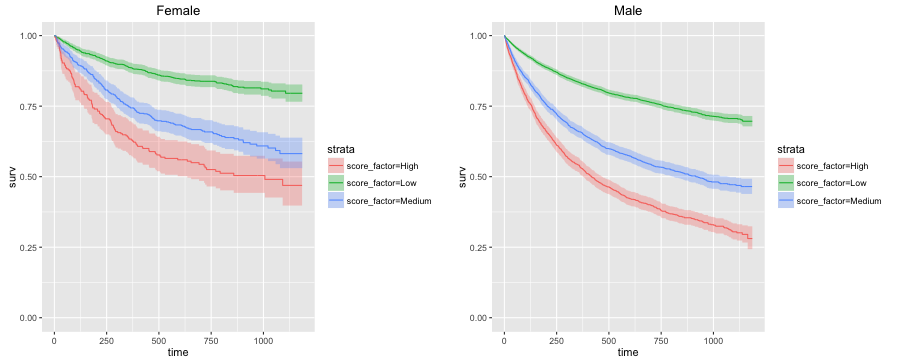

In [69]:
%%R -w 900 -h 363 -u px
grid.arrange(plotty(female_fit, "Female"), plotty(male_fit, "Male"),ncol=2)

As these plots show, the Compas score treats a High risk women the same as a Medium risk man.